In [1]:
import torch
import os
import pickle
from pytorch3d.ops import knn_points, knn_gather
import os.path as osp
import matplotlib.pyplot as plt
from glob import glob

## Visualize the voting space

### Get the input

In [2]:
output_root = '/home/shimingwang/workspace/sf_tv/sceneflow_tv_se'
output_folder =  'outputs/sf_voxel_model_new_dst_src_ckpt_17_best/25e5c600-36fe-3245-9cc0-40ef91620c22'

output_path = osp.join(output_root, output_folder)
print(output_path)
print
file_list = []
for file_name in glob(f'{output_path}/*.pkl'):
    file_list.append(file_name)

print(len(file_list))

/home/shimingwang/workspace/sf_tv/sceneflow_tv_se/outputs/sf_voxel_model_new_dst_src_ckpt_17_best/25e5c600-36fe-3245-9cc0-40ef91620c22
156


In [3]:
file_path = file_list[0]
print(file_path)

file_name = file_path.split('/')[-1]
print(file_name)

with open(file_path, 'rb') as f:
    outputs = pickle.load(f)

print(outputs.keys())   

/home/shimingwang/workspace/sf_tv/sceneflow_tv_se/outputs/sf_voxel_model_new_dst_src_ckpt_17_best/25e5c600-36fe-3245-9cc0-40ef91620c22/315966106959953000.pkl
315966106959953000.pkl
dict_keys(['input_batch', 'model_output', 'final_flow'])


In [4]:
input_batch = outputs['input_batch']
print(input_batch.keys())

model_output = outputs['model_output'] 
print(model_output.keys())

voting_vol = model_output['voting_vol']

print(voting_vol.shape)

dict_keys(['scene_id', 'timestamp', 'pc0', 'gm0', 'pose0', 'pc1', 'gm1', 'pose1', 'flow', 'flow_is_valid', 'flow_category_indices', 'ego_motion', 'origin_pc0'])
dict_keys(['pseudoimages_src', 'pseudoimages_dst', 'pseudoimages_grid', 'feats_voxel_src', 'feats_voxel_dst', 'voxels_src', 'voting_vol', 'points_src_offset', 'points_src_voxel_idx', 'flow', 'pc0_points_lst', 'pc1_points_lst', 'pc0_valid_point_idxes', 'pc1_valid_point_idxes', 'pose_flow'])
torch.Size([10764, 20, 20])


In [5]:
print(input_batch['pc0'].shape)
print(input_batch['pc1'].shape)
print('gt_flow:', input_batch['flow'].shape)  
print(model_output['voting_vol'].shape)
print(model_output['points_src_voxel_idx'].shape)
print(model_output['pc0_valid_point_idxes'].shape)
print(model_output['pc0_points_lst'].shape)
print(model_output['points_src_offset'].shape)

print(torch.eq(model_output['pc0_valid_point_idxes'], model_output['points_src_voxel_idx']).all())

print(model_output['pc0_valid_point_idxes'][:10], model_output['pc0_valid_point_idxes'].max())
print(model_output['points_src_voxel_idx'][:10], model_output['points_src_voxel_idx'].max())

torch.Size([71324, 3])
torch.Size([70819, 3])
gt_flow: torch.Size([95791, 3])
torch.Size([10764, 20, 20])
torch.Size([45371])
torch.Size([45371])
torch.Size([45371, 3])
torch.Size([45371, 3])
tensor(False, device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0') tensor(71322, device='cuda:0')
tensor([9077, 9078, 8795, 8795, 9088, 9088, 8814, 8814, 9125, 9103],
       device='cuda:0') tensor(10763, device='cuda:0')


In [6]:
flow = input_batch['flow']

flow = flow[model_output['pc0_valid_point_idxes']]
pose_flow = model_output['pose_flow'][model_output['pc0_valid_point_idxes']]
print(flow.shape)
print(pose_flow.shape)  


gt_flow = flow - pose_flow

torch.Size([45371, 3])
torch.Size([45371, 3])


### validate the gathering function

In [7]:
pc_src = input_batch['pc0'] ## after ground removal
valid_pts_mask = model_output['pc0_valid_point_idxes']
valid_pts = model_output['pc0_points_lst']
pts_src_offsets = model_output['points_src_offset']
pose_flow = model_output['pose_flow']


print(pc_src.shape)
print(valid_pts_mask.shape)
print(valid_pts.shape)
print(pts_src_offsets.shape)
print(pose_flow.shape)

pc_src_egm = pc_src + pose_flow 
valid_pts_from_mask = pc_src_egm[valid_pts_mask]
print(valid_pts_from_mask.shape)

print(valid_pts[:10, :])
print(valid_pts_from_mask[:10, :])
print(torch.eq(valid_pts, valid_pts_from_mask).all())

torch.Size([71324, 3])
torch.Size([45371])
torch.Size([45371, 3])
torch.Size([45371, 3])
torch.Size([71324, 3])
torch.Size([45371, 3])
tensor([[-35.8577,  30.4351,  -0.5454],
        [-35.7948,  30.4365,   0.5444],
        [-30.6650,  26.0558,  -2.3321],
        [-30.6177,  26.0568,  -1.3970],
        [-35.9227,  30.7315,  -0.5485],
        [-35.8280,  30.6706,   0.5462],
        [-30.6510,  26.2434,  -2.3385],
        [-30.6193,  26.2443,  -1.4018],
        [-36.0819,  31.0739,  -0.5535],
        [-35.8300,  30.9049,   0.5480]], device='cuda:0')
tensor([[-35.8577,  30.4351,  -0.5454],
        [-35.7948,  30.4365,   0.5444],
        [-30.6650,  26.0558,  -2.3321],
        [-30.6177,  26.0568,  -1.3970],
        [-35.9227,  30.7315,  -0.5485],
        [-35.8280,  30.6706,   0.5462],
        [-30.6510,  26.2434,  -2.3385],
        [-30.6193,  26.2443,  -1.4018],
        [-36.0819,  31.0739,  -0.5535],
        [-35.8300,  30.9049,   0.5480]], device='cuda:0')
tensor(False, device='cuda:0'

### a heatmap for voting space

In [8]:
print(voting_vol.shape)

torch.Size([10764, 20, 20])


In [9]:
import numpy as np  

In [15]:
voting_vol_np = voting_vol.cpu().numpy()

print(voting_vol_np.shape)

selected_idxes = np.random.choice(voting_vol_np.shape[0], 9, replace=False)

selected_vols = voting_vol_np[selected_idxes,...]

print(selected_vols.shape)

(10764, 20, 20)
(9, 20, 20)


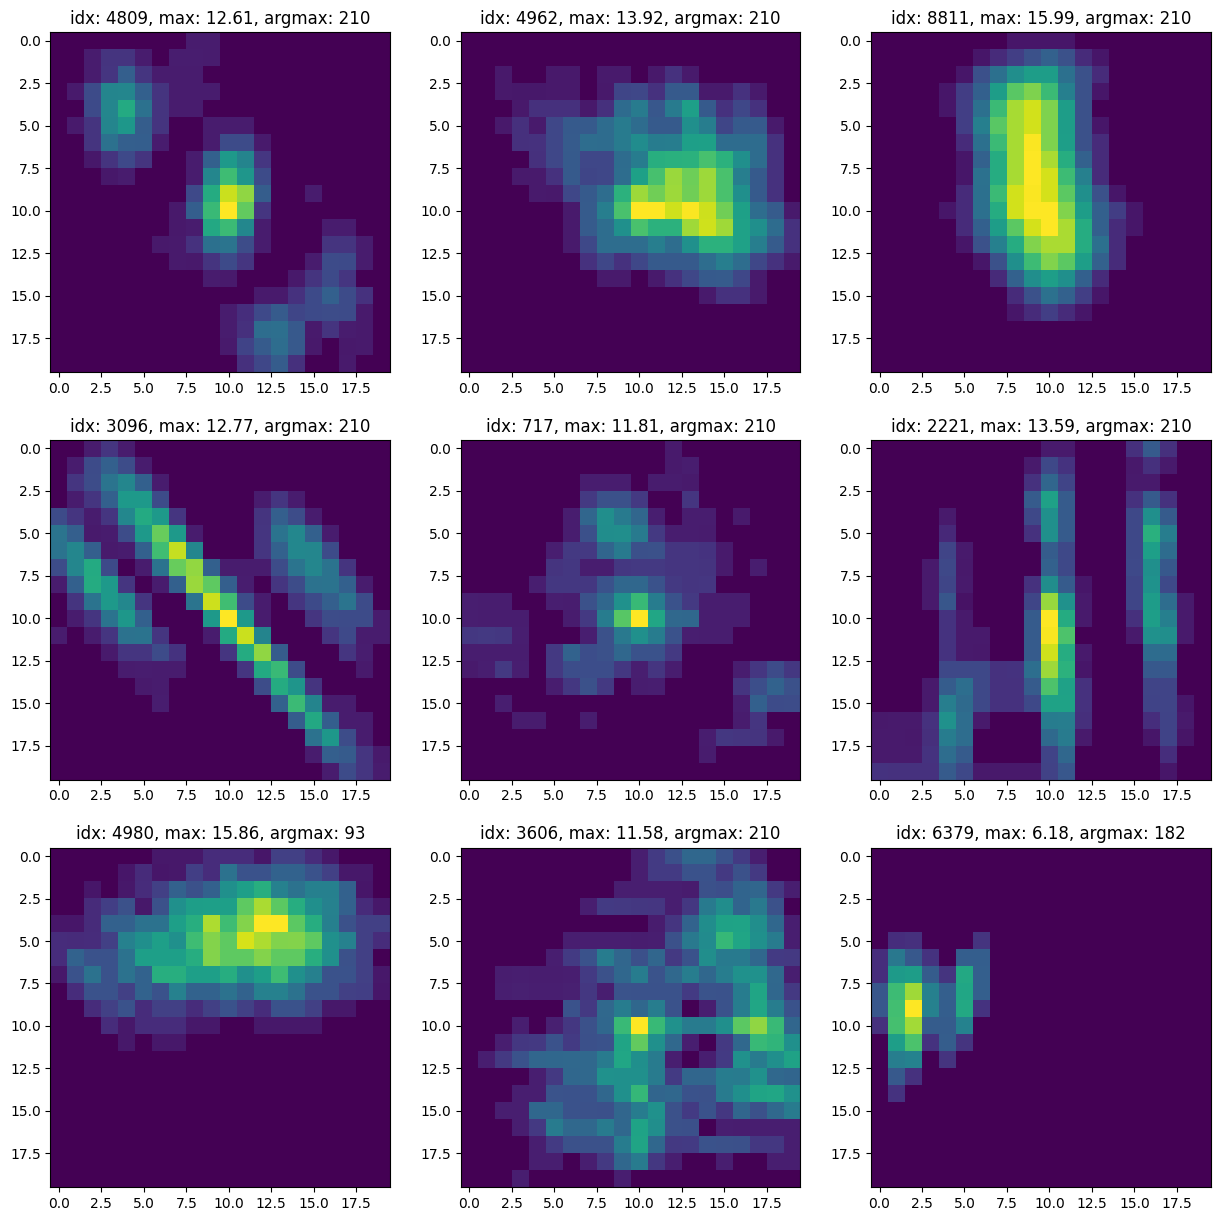

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(selected_vols[i*3+j, :, :])
        axs[i, j].axis('on')
        axs[i, j].set_title(f'idx: {selected_idxes[i*3+j]}, max: {selected_vols[i*3+j].max():.2f}, argmax: {np.argmax(selected_vols[i*3+j])}')

In [20]:
points_src_voxel_idx = model_output['points_src_voxel_idx']

print(points_src_voxel_idx.shape)

print(points_src_voxel_idx.max(), points_src_voxel_idx.min())

indices = (points_src_voxel_idx == 8811).nonzero()
print(indices)

print(gt_flow.shape)

selected_gt_flow = gt_flow[indices, :]
print(selected_gt_flow.shape)
print(selected_gt_flow)

selected_gt_flow_xy = selected_gt_flow.squeeze(1)[:, :2]


print(selected_gt_flow_xy)


print(selected_gt_flow_xy.mean(dim=0))


torch.Size([45371])
tensor(10763, device='cuda:0') tensor(0, device='cuda:0')
tensor([[21022],
        [21547],
        [21569],
        [21584],
        [42889],
        [43910],
        [44345],
        [44349],
        [44374],
        [44378]], device='cuda:0')
torch.Size([45371, 3])
torch.Size([10, 1, 3])
tensor([[[-3.1710e-05, -2.0229e-03, -3.0480e-02]],

        [[-7.6251e-04, -2.4232e-03, -1.7824e-02]],

        [[-1.3824e-03, -2.6962e-03, -6.2127e-03]],

        [[-7.2272e-04, -3.0253e-03, -2.8279e-02]],

        [[ 9.3785e-04, -1.3312e-03, -4.4652e-02]],

        [[-8.4673e-04,  2.5218e-03,  6.0582e-02]],

        [[ 5.8130e-03,  5.7440e-03, -6.0644e-02]],

        [[ 4.4941e-03,  3.6963e-03, -5.8328e-02]],

        [[-5.0594e-04,  5.5570e-04,  2.1522e-02]],

        [[-1.7428e-03, -1.4761e-03,  2.1920e-02]]], device='cuda:0')
tensor([[-3.1710e-05, -2.0229e-03],
        [-7.6251e-04, -2.4232e-03],
        [-1.3824e-03, -2.6962e-03],
        [-7.2272e-04, -3.0253e-03],
       

### get the Rough Flow of the voting space

In [24]:
ref_y, ref_x = torch.meshgrid(torch.linspace(-3.3, 3.3, 34),torch.linspace(-3.3, 3.3 , 34))

print(ref_y.shape)
print(ref_x.shape)

flow_coord = torch.stack((ref_y, ref_x), dim=-1)

print(flow_coord.shape)

print(flow_coord[0, 0, :])
print(flow_coord[0, -1, :])
print(flow_coord[-1, 0, :])
print(flow_coord[-1, -1, :])

flow_coord = flow_coord.view(-1, 2)
print(flow_coord.shape)

torch.Size([34, 34])
torch.Size([34, 34])
torch.Size([34, 34, 2])
tensor([-3.3000, -3.3000])
tensor([-3.3000,  3.3000])
tensor([ 3.3000, -3.3000])
tensor([3.3000, 3.3000])
torch.Size([1156, 2])


In [25]:
print(voting_vol.shape)

vols_flattened = voting_vol.view(voting_vol.shape[0], -1)
print(vols_flattened.shape)

topk_voting, topk_idx = torch.topk(vols_flattened, 5, dim=-1)
print(topk_voting.shape)
print(topk_idx.shape)

gathered_vol = torch.gather(vols_flattened, dim =1, index = topk_idx)

print(torch.eq(gathered_vol, topk_voting).all())    


print(topk_voting[:20, :])
print(topk_voting.max(), topk_voting.min())

torch.Size([10764, 20, 20])
torch.Size([10764, 400])
torch.Size([10764, 5])
torch.Size([10764, 5])
tensor(True, device='cuda:0')
tensor([[ 3.0000,  2.9041,  1.9402,  1.8202,  0.9039],
        [ 3.0000,  2.9041,  1.9402,  1.8202,  0.9039],
        [ 3.0000,  2.9041,  1.9402,  1.8202,  0.9039],
        [ 3.0000,  2.9041,  1.9402,  1.8202,  0.9039],
        [10.6307,  8.4798,  8.2190,  7.4686,  7.0000],
        [10.7707,  7.9169,  7.8367,  6.7843,  6.7374],
        [ 4.1143,  3.9244,  3.6401,  3.5633,  3.3959],
        [ 5.1152,  4.5184,  4.0802,  3.9411,  3.6987],
        [ 6.2802,  5.2490,  4.6577,  4.5939,  4.5135],
        [ 8.3117,  6.1352,  5.9566,  4.8209,  4.3512],
        [ 8.3117,  6.1352,  5.9566,  5.7423,  4.3512],
        [ 5.4468,  3.8573,  3.3375,  3.0000,  2.5130],
        [11.8855,  9.6212,  9.2868,  8.5074,  7.6796],
        [11.7966, 10.5654,  9.5365,  8.2984,  8.0798],
        [11.8027, 10.4621,  9.4674,  8.7590,  8.3645],
        [11.7124, 10.5640,  9.2797,  8.8155,  

### get the corresponding rough flow

In [26]:
print(flow_coord.shape, flow_coord.device)
print(topk_idx.shape, topk_idx.device)

flow_coord = flow_coord.to(topk_idx.device)
voting_rough_flow = knn_gather(x=flow_coord[None], idx=topk_idx[None])

print(voting_rough_flow.shape)

voting_rough_flow = voting_rough_flow.squeeze(0)


torch.Size([1156, 2]) cpu
torch.Size([10764, 5]) cuda:0
torch.Size([1, 10764, 5, 2])


In [27]:
voting_rough_flow_distance = torch.norm(voting_rough_flow, dim=-1)
print(voting_rough_flow_distance.shape)
print(voting_rough_flow_distance.max(), voting_rough_flow_distance.min())

voting_rough_flow_distance_top1 = voting_rough_flow_distance[:, 0]

print(voting_rough_flow_distance_top1.shape)
print(voting_rough_flow_distance_top1.max(), voting_rough_flow_distance_top1.min())

torch.Size([10764, 5])
tensor(4.6669, device='cuda:0') tensor(1.1045, device='cuda:0')
torch.Size([10764])
tensor(4.6669, device='cuda:0') tensor(1.1402, device='cuda:0')


### project back to the points level

In [28]:
points_src_voxel_idx = model_output['points_src_voxel_idx']

print(voting_rough_flow_distance[None].shape)
print(points_src_voxel_idx[None,:,None].shape)
points_src_rough_flow_dist = knn_gather(x=voting_rough_flow_distance[None], idx=points_src_voxel_idx[None,:,None])

print(points_src_rough_flow_dist.shape)

points_src_rough_flow_dist_top1 = points_src_rough_flow_dist.squeeze(0).squeeze(1)[:, 0]

print(points_src_rough_flow_dist_top1.shape)

print(points_src_rough_flow_dist_top1.max(), points_src_rough_flow_dist_top1.min())

torch.Size([1, 10764, 5])
torch.Size([1, 45371, 1])
torch.Size([1, 45371, 1, 5])
torch.Size([45371])
tensor(4.6669, device='cuda:0') tensor(1.1402, device='cuda:0')


In [29]:
import numpy as np

### Get histogram of the voting space

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4. ]


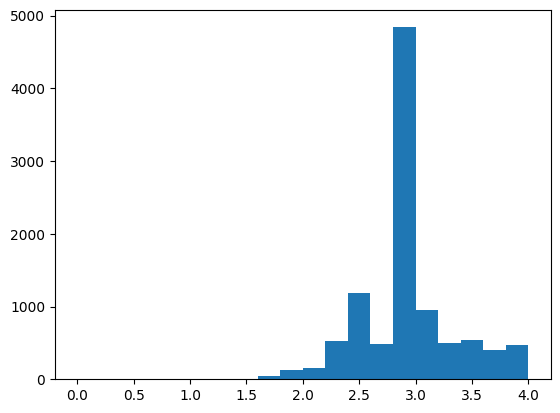

In [30]:
bins = np.linspace(0, 4, 21)

print(bins)

counts, bins = np.histogram(voting_rough_flow_distance_top1.cpu().numpy(), bins=bins)
plt.stairs(counts, bins, fill=True)

### Get histogram of point levels

[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4. ]


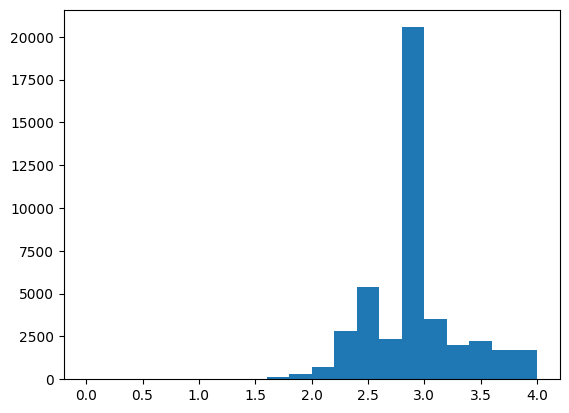

In [31]:
bins = np.linspace(0, 4, 21)

print(bins)

counts, bins = np.histogram(points_src_rough_flow_dist_top1.cpu().numpy(), bins=bins)
plt.stairs(counts, bins, fill=True)

### Histogram of gt flow

torch.Size([45371, 3])
torch.Size([45371])
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4. ]


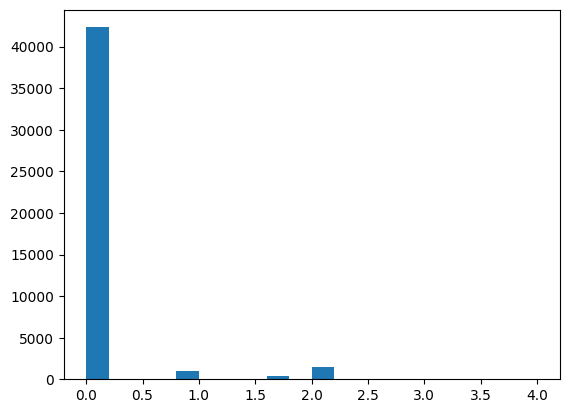

In [32]:
print(gt_flow.shape)

gt_flow_distance = torch.norm(gt_flow, dim=-1)

print(gt_flow_distance.shape)

bins = np.linspace(0, 4, 21)

print(bins)

counts, bins = np.histogram(gt_flow_distance.cpu().numpy(), bins=bins)
plt.stairs(counts, bins, fill=True)

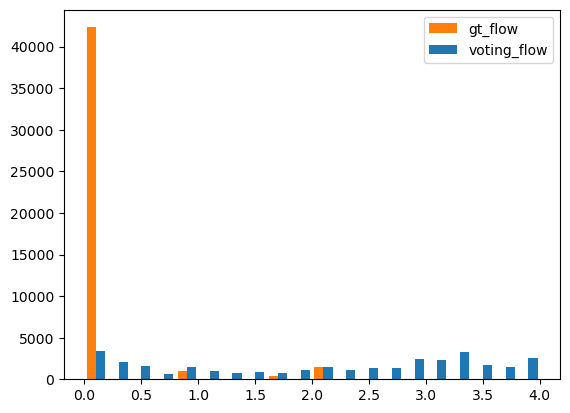

In [34]:
fig, ax = plt.subplots()    

gt_flow = gt_flow_distance.cpu().numpy()
voting_flow = points_src_rough_flow_dist_top1.cpu().numpy()
ax.hist((gt_flow, voting_flow), bins=bins, histtype='bar', color=['C1', 'C0'], label=['gt_flow', 'voting_flow'])
ax.legend(prop={'size': 10})

## A for loop for all the samples

In [38]:
ref_y, ref_x = torch.meshgrid(torch.linspace(-3.3, 3.3, 34),torch.linspace(-3.3, 3.3 , 34))

print(ref_y.shape)
print(ref_x.shape)

flow_coord = torch.stack((ref_y, ref_x), dim=-1)

print(flow_coord.shape)

print(flow_coord[0, 0, :])
print(flow_coord[0, -1, :])
print(flow_coord[-1, 0, :])
print(flow_coord[-1, -1, :])

flow_coord = flow_coord.view(-1, 2)
print(flow_coord.shape)

torch.Size([34, 34])
torch.Size([34, 34])
torch.Size([34, 34, 2])
tensor([-3.3000, -3.3000])
tensor([-3.3000,  3.3000])
tensor([ 3.3000, -3.3000])
tensor([3.3000, 3.3000])
torch.Size([1156, 2])


In [39]:
from tqdm import tqdm

In [40]:
voting_flow_list = []
gt_flow_list = []

for file_path in tqdm(file_list):
    # print(file_path)
    f = open(file_path, 'rb')
    outputs = pickle.load(f)
    f.close()

    input_batch = outputs['input_batch']
    model_output = outputs['model_output']
    
    voting_vol = model_output['voting_vol'].cpu()
    pc0_valid_point_idxes = model_output['pc0_valid_point_idxes'].cpu()
    points_src_voxel_idx = model_output['points_src_voxel_idx'].cpu()
    
    flow = input_batch['flow'][pc0_valid_point_idxes].cpu()
    pose_flow = model_output['pose_flow'][pc0_valid_point_idxes].cpu()

    gt_flow = flow - pose_flow
    

    vols_flattened = voting_vol.view(voting_vol.shape[0], -1)

    topk_voting, topk_idx = torch.topk(vols_flattened, 5, dim=-1)

    flow_coord = flow_coord.to(topk_idx.device)
    
    voting_rough_flow = knn_gather(x=flow_coord[None], idx=topk_idx[None])
    
    voting_rough_flow_distance = torch.norm(voting_rough_flow, dim=-1)
    
    mask = points_src_voxel_idx[None,:,None] > 0
    fill_value = -1
    
    idx = points_src_voxel_idx[None,:,None].long()
    idx[~mask] = 0
    
    points_src_rough_flow_dist = knn_gather(x=voting_rough_flow_distance, idx=idx)
    
    points_src_rough_flow_dist[~mask] = fill_value
    
    points_src_rough_flow_dist_top1 = points_src_rough_flow_dist.squeeze(0).squeeze(1)[:, 0]
    gt_flow_distance = torch.norm(gt_flow, dim=-1)

    gt_flow_ = gt_flow_distance.numpy()
    voting_flow_ = points_src_rough_flow_dist_top1.cpu().numpy()
    
    # assert len(gt_flow_) == len(voting_flow_), f'gt flow:,{len(gt_flow_)}, voting flow: {len(voting_flow_)}, {file_path}'
    gt_flow_list.append(gt_flow_)
    voting_flow_list.append(voting_flow_)


  0%|          | 0/156 [00:00<?, ?it/s]

100%|██████████| 156/156 [00:33<00:00,  4.63it/s]


In [14]:
import numpy as np

In [15]:
print(len(gt_flow_list))
print(len(voting_flow_list))

gt_flow_val_demo = np.concatenate(gt_flow_list, axis=0)
voting_flow_val_demo = np.concatenate(voting_flow_list, axis=0)

print(gt_flow_val_demo.shape)
print(voting_flow_val_demo.shape)

156
156
(6865751,)
(6883187,)


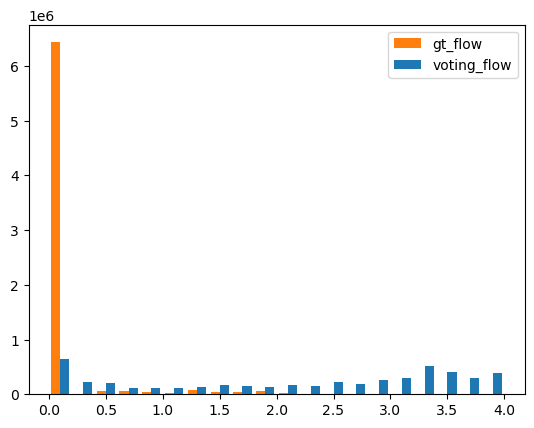

In [17]:
fig, ax = plt.subplots()    
bins = np.linspace(0, 4, 21)
ax.hist((gt_flow_val_demo, voting_flow_val_demo), bins=bins, histtype='bar', color=['C1', 'C0'], label=['gt_flow', 'voting_flow'])
ax.legend(prop={'size': 10})